In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cnfg
import re
import os
from sqlalchemy import create_engine
from gensim import corpora, models, similarities, matutils
from sklearn.preprocessing import Normalizer, normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from gensim.models import word2vec
from gensim import models
from collections import defaultdict
from sklearn.manifold import TSNE

import logging
from sklearn.decomposition import TruncatedSVD, NMF

# logging for gensim (set to INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline

In [2]:
config = cnfg.load(".metis_config")
engine = create_engine('postgresql://{}:{}@{}:5432/{}'.format(
                        config['db_user'],
                        config['db_pwd'],
                        config['db_host'],
                        'sephora'))

query_product = """SELECT * FROM sephora_product WHERE category IN ('moisturizers', 'face serums', 'face wash & cleansers',
         'eye creams & treatments', 'face masks', 'moisturizer & treatments',
         'face oils')"""
df_product = pd.read_sql_query(query_product, engine)
# df_product = pd.read_csv('data/sephora_product.csv')
df_product = df_product.set_index('id')
df_product.head(3)

,product_url,sku,category,brand,name,rating,detail_text,size_oz,price
id,,,,,,,,,
P102503,/wrinkle-revenge-rescue-protect-facial-cream-P...,844480,moisturizers,DERMAdoctor,Wrinkle Revenge Rescue & Protect Facial Cream,4.2366,What it is:A lightweight concentrate that deli...,1.7,57
P102504,/wrinkle-revenge-eye-balm-P102504,844472,eye creams & treatments,DERMAdoctor,Wrinkle Revenge Eye Balm,4.0591,What it is:A super-hydrating eye balm enriched...,0.5,50
P107306,/renewing-eye-cream-P107306,769836,eye creams & treatments,Murad,Renewing Eye Cream,4.0706,"What it is: A multiactive, antiaging treatment...",0.5,80


In [3]:
query_review = 'SELECT * FROM sephora_product_review'
df = pd.read_sql_query(query_review, engine)
# df = pd.read_csv('data/sephora_review.csv')
df = df[df.rating <= 3]
df.head()

,product_id,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_id
3,P38217,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]",248c904c-6e30-4929-8228-87b03ad7a921
9,P38217,,"i like it, but not so crazy about the smell.",3,None,combination,medium,None,tweezerama,[foamy],72c2a20a-be1c-46dc-a2cd-142f2110a05d
18,P38217,Stings my eyes,Returned this product as it was to foamy to us...,1,None,normal,light,None,nancihi,[foamy],ebf96058-5203-4494-9a6c-2bb74099ad23
35,P38217,Wanted to like this but . . .,I received a sample of this cleanser and reall...,2,None,combination,olive,None,rsav,None,639284c9-016e-4bfa-a136-e08e131beefb
43,P38217,Murad cleaners,Good cleanser but I do not care for the scent....,2,None,combination,medium,None,Debedot,None,477b3329-f764-4935-8980-1e24a223f2b6


In [4]:
# df = df.set_index('review_id')

# Split review_text into sentences
punkt_param = PunktParameters()
punkt_param.abbrev_types = set(['dr', 'vs', 'mr', 'mrs'])
tokenizer = PunktSentenceTokenizer(punkt_param)
tokenizer.tokenize('Dr. Smith is a doctor. He is the best ... not')

['Dr. Smith is a doctor.', 'He is the best ... not']

In [5]:
df['review_sentences'] = df['review_text'].map(lambda text: tokenizer.tokenize(text))

In [6]:
sample_review_index = 1
print(df.iloc[sample_review_index]['review_text'])
df.iloc[sample_review_index]['review_sentences']

i like it, but not so crazy about the smell.


['i like it, but not so crazy about the smell.']

In [7]:
# Build a new dataframe with each sentence as a document
review_ids = []
review_sentences = []
for review in df.as_matrix():
    curr_review_id = review[-2]
    curr_review_sentences = review[-1]
    review_ids += [curr_review_id] * len(curr_review_sentences)
    review_sentences += curr_review_sentences
    
df_review_sentences = pd.DataFrame({'review_id': review_ids, 'sentence': review_sentences})
df_review_sentences.head()

,review_id,sentence
0,248c904c-6e30-4929-8228-87b03ad7a921,"I tried this cleanser at a friends house, and ..."
1,248c904c-6e30-4929-8228-87b03ad7a921,"I have combination skin, oily t-zone with flak..."
2,248c904c-6e30-4929-8228-87b03ad7a921,"After washing my face with this cleanser, my s..."
3,248c904c-6e30-4929-8228-87b03ad7a921,"However, it has been a week and my pores very ..."
4,72c2a20a-be1c-46dc-a2cd-142f2110a05d,"i like it, but not so crazy about the smell."


In [8]:
df_review_sentences.shape

(100051, 2)

In [9]:
tokenizer_regex = re.compile(r"[\s]")

def tokenize(text):
    clean_text = re.sub(r'[,!.$\d%&~?()#<>"=/-]', ' ', text)
    clean_text = ' '.join(clean_text.split())
    return [tok.strip().lower() for tok in tokenizer_regex.split(clean_text)]

## TF-IDF

In [10]:
def get_word_weights(docs):
    tfidf = TfidfVectorizer(stop_words=frozenset(), 
                            tokenizer=tokenize,
                            ngram_range=(1,1))
    tfidf.fit(docs)
    max_idf = max(tfidf.idf_)
    word2weight = defaultdict(lambda: max_idf,
                                    [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    return word2weight
    
test_docs2 = ["dog cat fish","dog cat cat","fish bird", 'bird fish. bird', 'blah cat', 'tata harper']
get_word_weights(test_docs2)

defaultdict(<function __main__.get_word_weights.<locals>.<lambda>>,
            {'bird': 1.8472978603872037,
             'blah': 2.2527629684953681,
             'cat': 1.5596157879354227,
             'dog': 1.8472978603872037,
             'fish': 1.5596157879354227,
             'harper': 2.2527629684953681,
             'tata': 2.2527629684953681})

## Word2Vec

In [11]:
w2v = models.KeyedVectors.load_word2vec_format("../GoogleNews-vectors-negative300.bin",binary=True)

2017-08-22 19:06:29,537 : INFO : loading projection weights from ../GoogleNews-vectors-negative300.bin
2017-08-22 19:07:42,829 : INFO : loaded (3000000, 300) matrix from ../GoogleNews-vectors-negative300.bin


In [12]:
# np.mean(w2v[['it\'s', 'is', 'moisturizer', 'reviews']], axis=0)
# w2v['moisturizer']

In [13]:
w2v.most_similar(positive=['breakouts'], topn=25)

2017-08-22 19:07:42,840 : INFO : precomputing L2-norms of word weight vectors


[('Breakouts', 0.4931666851043701),
 ('Pullbacks', 0.44811978936195374),
 ('retracements', 0.44314947724342346),
 ('negative_divergences', 0.4385339021682739),
 ('ascending_triangle_formation', 0.4347585439682007),
 ('downtrending', 0.4336913228034973),
 ('optionable', 0.4287429451942444),
 ('QCOR', 0.42023026943206787),
 ('breakout', 0.4135875701904297),
 ('ALLT', 0.4107140898704529),
 ('Aud_Usd', 0.405377060174942),
 ('overbought_oversold', 0.4032655358314514),
 ('TZOO', 0.40304189920425415),
 ('upmoves', 0.4025312662124634),
 ('dojis', 0.39710044860839844),
 ('CSIQ', 0.396085262298584),
 ('CROX', 0.39557570219039917),
 ('AKRX', 0.3948154151439667),
 ('DSTI', 0.3942748010158539),
 ('CYCC', 0.39323264360427856),
 ('largecap_stocks', 0.3913867473602295),
 ('stochastics', 0.39073675870895386),
 ('microcap_stocks', 0.3889700770378113),
 ('MACD_divergence', 0.3887573480606079),
 ('bearish_engulfing', 0.3871125280857086)]

In [14]:
'review' in w2v.vocab

True

In [15]:
df_review_sentences['tokenized_words'] = df_review_sentences['sentence'].map(lambda sentence: tokenize(sentence))
df_review_sentences['tokenized_filtered_words'] = df_review_sentences['tokenized_words'].map(
    lambda tokenized_words: [word for word in tokenized_words if word in w2v.vocab])
df_review_sentences['tokenized_filtered_words_length'] = df_review_sentences['tokenized_filtered_words'].map(
    lambda tokenized_filtered_words: len(tokenized_filtered_words))

In [16]:
# Remove sentences that have no words
df_review_sentences = df_review_sentences[df_review_sentences.tokenized_filtered_words_length > 0]
df_review_sentences = df_review_sentences.reset_index()
word2weight = get_word_weights(df_review_sentences['sentence'])
word2weight

defaultdict(<function __main__.get_word_weights.<locals>.<lambda>>,
            {'hidden': 10.561701221091147,
             'ness': 10.109716097348089,
             'buttttt': 11.814464189586515,
             'stubborn': 8.8700252104200743,
             'robbery': 11.814464189586515,
             'crush': 11.814464189586515,
             'boscia': 7.3836473907432012,
             'culprit': 8.9522633086570451,
             'coarse': 11.121317009026569,
             'irritate': 6.9430909628237663,
             'grief': 11.408999081478349,
             'adored': 10.898173457712359,
             'flattend': 11.814464189586515,
             'standard': 9.4630889324230374,
             "'oily'": 11.814464189586515,
             'imposible': 11.814464189586515,
             'bumpy': 8.5002781849139879,
             'fact': 6.4163014880687612,
             'sadlly': 11.814464189586515,
             'dirty': 8.1255847354725788,
             'directed': 7.5949564844104076,
             'intends

In [17]:
# For each sentence, find word2vec vector
# np.mean(w2v[['it\'s', 'is', 'moisturizer', 'reviews']], axis=0)
def word2vec_tfidf(tokenized_filtered_words):
    return np.mean([w2v[w] * word2weight[w]
             for w in tokenized_filtered_words], axis=0)

word2vec_tfidf(['apple', 'banana']).shape

(300,)

In [18]:
df_review_sentences['word2vec'] = df_review_sentences['tokenized_filtered_words'].map(
    # lambda tokenized_filtered_words: np.mean(w2v[tokenized_filtered_words], axis=0)
    lambda tokenized_filtered_words: word2vec_tfidf(tokenized_filtered_words)
)
df_review_sentences.head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec
0,0,248c904c-6e30-4929-8228-87b03ad7a921,"I tried this cleanser at a friends house, and ...","[i, tried, this, cleanser, at, a, friends, hou...","[i, tried, this, cleanser, at, friends, house,...",12,"[0.520117, -0.108023, 0.450239, 0.52766, -0.32..."
1,1,248c904c-6e30-4929-8228-87b03ad7a921,"I have combination skin, oily t-zone with flak...","[i, have, combination, skin, oily, t, zone, wi...","[i, have, combination, skin, oily, t, zone, wi...",16,"[-0.145785, 0.131083, 0.00567749, 0.335053, -1..."
2,2,248c904c-6e30-4929-8228-87b03ad7a921,"After washing my face with this cleanser, my s...","[after, washing, my, face, with, this, cleanse...","[after, washing, my, face, with, this, cleanse...",22,"[-0.0107178, 0.344289, 0.0608665, 0.136298, -0..."
3,3,248c904c-6e30-4929-8228-87b03ad7a921,"However, it has been a week and my pores very ...","[however, it, has, been, a, week, and, my, por...","[however, it, has, been, week, my, pores, very...",22,"[0.140816, 0.620424, -0.23117, 0.109888, -0.60..."
4,4,72c2a20a-be1c-46dc-a2cd-142f2110a05d,"i like it, but not so crazy about the smell.","[i, like, it, but, not, so, crazy, about, the,...","[i, like, it, but, not, so, crazy, about, the,...",10,"[0.214878, -0.0328662, 0.166154, 0.303838, -0...."


In [19]:
# pd.DataFrame(df_review_sentences['word2vec'].values.tolist())

In [20]:
sentence_word_vectors = np.array(df_review_sentences['word2vec'].values.tolist())

## Clustering Functions

In [21]:
def plot_kmeans_inertia(data):
    """Figure out optimized number of clusters for KMeans"""
    max_number_clusters = 20
    inertia_values = []
    for cluster_count in range(1, max_number_clusters+1):
        print('fitting cluster ', cluster_count)
        km = KMeans(n_clusters=cluster_count)
        km.fit(data)
        inertia_values.append(km.inertia_)

    plt.plot(range(1, max_number_clusters+1), inertia_values)

## K-Means

In [22]:
sentence_word_vectors.shape

(99469, 300)

In [23]:
cluster_count = 50
number_sentences = sentence_word_vectors.shape[0]
df_review_sentences_truncated = df_review_sentences.iloc[0:number_sentences, :]
sentence_word_vectors_truncated = sentence_word_vectors[0:number_sentences, :]
sentence_word_vectors_truncated = normalize(sentence_word_vectors_truncated)
sentence_word_vectors_truncated.shape

(99469, 300)

In [24]:
# plot_kmeans_inertia(sentence_word_vectors_truncated)

In [25]:
km = MiniBatchKMeans(n_clusters=cluster_count)
review_word2vec_clusters = km.fit_predict(sentence_word_vectors_truncated)
dists = km.transform(sentence_word_vectors_truncated)
disd_df = pd.DataFrame(dists)
nearest_to_centers = list(disd_df.idxmin(axis=0))
cluster_sentence_counts = []

for i in range(cluster_count):
    word2vec_review_cluster = df_review_sentences_truncated.loc[review_word2vec_clusters == i]['sentence']
    nearest_to_center_sentence_index = nearest_to_centers[i] 
    cluster_sentence_count = word2vec_review_cluster.shape[0]
    cluster_sentence_counts.append(cluster_sentence_count)
    print('Cluster {} has {} sentences'.format(i, cluster_sentence_count))
    print(df_review_sentences.iloc[nearest_to_center_sentence_index]['sentence'])
    
    data_cluster_file = 'data/cluster_reviews/cluster_' + str(i) + '.txt'
    cluster_file = open(data_cluster_file, 'w') 
    for review_text in word2vec_review_cluster.as_matrix():
        cluster_file.write(review_text + '\n')
    cluster_file.close()

Cluster 0 has 210 sentences
waste money !
Cluster 1 has 6577 sentences
I wanted it to work, I guess I'm just unlucky but this did NOTHING what so ever for my acne, didn't get worse or better just nothing it was as if I was applying nothing on my skin and I really had high hopes of this working because the sales associates say its "DA BOMB" and everyone els reviewing seems to love it :( I JUST WANTED IT TO WORK :((( I eventually couldn't do it anymore and returned it and tip: IT DOESNT RUN OUT fast <3 I used 2-3 pumps for my whole face (yes i like to use a lot) and I didn't even use 1/10 of the product in 3 weeks IT LASTS SO long and I use so much so It seems like a fab brand and the packaging is so sexy but it didn't work sadly probably just me but I would encourage you to try it because we all don't have the same skin types and AHA and BHA in one product is heaven so try it out and if it works for you <3 if it doesn't call me and we can cry together.
Cluster 2 has 15 sentences
It alwa

Cluster 46 has 2514 sentences
This product makes no difference on my skin, I did not notice any change after using it for 2 weeks.
Cluster 47 has 2614 sentences
Unfortunately, this was gloppy (not just thick...I love thick moisturizing creams) but really gloppy and hard to smooth into the skin and it felt slightly irritating to my skin.
Cluster 48 has 2 sentences
Im 20 and i decided i wanted to up my skin care routine by adding an eyecream.
Cluster 49 has 2505 sentences
I PURSCHASED THIS FOR $93.00-HOPING IT WOULD WORK-But it didn't do anything miraculaus-it did cause me to get bumps-so i really wanted to like this-i figure for the high price it would work not true-i have a sew lines- and dryness-so didn't help either-i tried to give it sometime 6 weeks-and i got bumps and know results-so now i stop using it-my eyes are healing-not good for me that is for sure-my search goes on


<Container object of 50 artists>

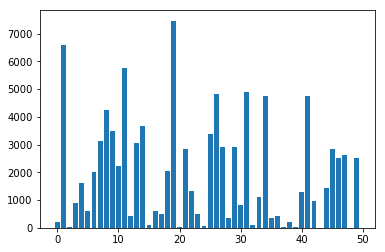

In [26]:
plt.bar(range(0, cluster_count), cluster_sentence_counts)

In [27]:
disd_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.184614,0.803748,1.007876,0.997011,0.846318,0.989729,0.872985,0.809650,0.804871,0.803888,...,0.849611,0.775662,0.861852,1.009539,0.809944,0.770992,0.871207,0.851609,0.926385,0.826520
1,1.219466,0.906878,1.079622,1.028467,0.779246,1.045488,0.719323,0.665929,0.881067,0.804005,...,0.985240,0.736881,0.804888,1.015114,0.736378,0.893959,0.873091,0.708915,1.019022,0.921541
2,1.135380,0.816856,0.875764,1.011612,0.731666,0.939630,0.670208,0.643879,0.773013,0.725101,...,0.887314,0.556721,0.678390,0.962570,0.691142,0.801775,0.833549,0.610681,0.928645,0.816980
3,1.166705,0.724890,0.854587,0.900869,0.580269,0.922871,0.626583,0.529524,0.683738,0.681425,...,0.818370,0.599177,0.582699,0.842832,0.619224,0.712159,0.678720,0.627030,0.923649,0.735690
4,1.075717,0.540551,0.877090,0.871029,0.696723,0.781805,0.758480,0.718095,0.722723,0.520649,...,0.640465,0.698945,0.737109,0.873226,0.706075,0.654110,0.696112,0.716419,0.917874,0.677436


In [28]:
len(review_word2vec_clusters)

99469

In [29]:
# Create vector of sentence to cluster number
df_sentence_cluster = pd.DataFrame({})
cluster_columns = ['cluster_' + str(i) for i in range(0, cluster_count)]
for i in range(0, cluster_count):
    cluster_column = cluster_columns[i]
    df_sentence_cluster[cluster_column] = (review_word2vec_clusters == i).astype(int)
    
df_sentence = pd.concat([df_review_sentences, df_sentence_cluster], axis=1)
df_sentence[df_sentence['cluster_0'] == 1].head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,cluster_0,cluster_1,cluster_2,...,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47,cluster_48,cluster_49
726,732,d73a3cc9-519d-4003-b66a-7aab8416a380,waste money !,"[waste, money]","[waste, money]",2,"[-0.17283, 1.28001, 1.35975, 1.08507, -0.77841...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
1651,1660,bd7d0aa7-d00d-4fd7-b554-913765b88204,Waste of money.,"[waste, of, money]","[waste, money]",2,"[-0.17283, 1.28001, 1.35975, 1.08507, -0.77841...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
1861,1871,afd974bb-8929-4f90-a1b0-54a86a97fc13,Waste.,[waste],[waste],1,"[-1.16955, 2.29301, 2.37367, 1.07161, -1.73992...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
2404,2418,57e7f873-45e2-4795-9f5f-22e795f0ee67,What a waste!,"[what, a, waste]","[what, waste]",2,"[-0.239391, 1.13126, 1.7182, 0.715743, -1.2684...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
2524,2541,6b1b79f0-9a04-4679-8c95-d9bd89a8db01,Another product for the landfill.,"[another, product, for, the, landfill]","[another, product, for, the, landfill]",5,"[-0.350848, 0.274177, 1.02394, 0.395908, -0.22...",1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Merging Review Sentences with Products

In [30]:
df_sentence_product = pd.merge(df_sentence, df, on='review_id', how='left')
df_sentence_product.head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,cluster_0,cluster_1,cluster_2,...,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_sentences
0,0,248c904c-6e30-4929-8228-87b03ad7a921,"I tried this cleanser at a friends house, and ...","[i, tried, this, cleanser, at, a, friends, hou...","[i, tried, this, cleanser, at, friends, house,...",12,"[0.520117, -0.108023, 0.450239, 0.52766, -0.32...",0,0,0,...,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]","[I tried this cleanser at a friends house, and..."
1,1,248c904c-6e30-4929-8228-87b03ad7a921,"I have combination skin, oily t-zone with flak...","[i, have, combination, skin, oily, t, zone, wi...","[i, have, combination, skin, oily, t, zone, wi...",16,"[-0.145785, 0.131083, 0.00567749, 0.335053, -1...",0,0,0,...,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]","[I tried this cleanser at a friends house, and..."
2,2,248c904c-6e30-4929-8228-87b03ad7a921,"After washing my face with this cleanser, my s...","[after, washing, my, face, with, this, cleanse...","[after, washing, my, face, with, this, cleanse...",22,"[-0.0107178, 0.344289, 0.0608665, 0.136298, -0...",0,0,0,...,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]","[I tried this cleanser at a friends house, and..."
3,3,248c904c-6e30-4929-8228-87b03ad7a921,"However, it has been a week and my pores very ...","[however, it, has, been, a, week, and, my, por...","[however, it, has, been, week, my, pores, very...",22,"[0.140816, 0.620424, -0.23117, 0.109888, -0.60...",0,0,0,...,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]","[I tried this cleanser at a friends house, and..."
4,4,72c2a20a-be1c-46dc-a2cd-142f2110a05d,"i like it, but not so crazy about the smell.","[i, like, it, but, not, so, crazy, about, the,...","[i, like, it, but, not, so, crazy, about, the,...",10,"[0.214878, -0.0328662, 0.166154, 0.303838, -0....",0,0,0,...,,"i like it, but not so crazy about the smell.",3,None,combination,medium,None,tweezerama,[foamy],"[i like it, but not so crazy about the smell.]"


In [31]:
df_sentence_products_clusters = df_sentence_product[cluster_columns + ['product_id']].groupby(['product_id']).sum()
df_sentence_products_clusters.head() # Unnormalized, Uncentered

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47,cluster_48,cluster_49
product_id,,,,,,,,,,,,,,,,,,,,,
P102503,0,3,0,0,0,1,0,0,5,2,...,0,3,2,0,0,1,1,1,0,3
P102504,2,18,0,2,19,3,2,8,23,0,...,8,3,2,0,3,4,7,7,0,6
P107306,0,13,0,4,13,2,3,12,12,0,...,3,1,1,0,0,7,7,4,0,6
P112400,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
P113608,0,14,0,1,0,0,2,2,4,15,...,0,5,1,0,0,3,6,1,0,2


In [32]:
df_products_cluster_centered = df_sentence_products_clusters - df_sentence_products_clusters.mean()
df_products_cluster_centered.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47,cluster_48,cluster_49
product_id,,,,,,,,,,,,,,,,,,,,,
P102503,-0.166139,-2.203323,-0.011867,-0.711234,-1.291139,0.511867,-1.594146,-2.469937,1.635285,-0.762658,...,-1.022943,-0.766614,1.232595,-0.007911,-1.125,-1.247627,-0.988924,-1.068038,-0.001582,1.018196
P102504,1.833861,12.796677,-0.011867,1.288766,17.708861,2.511867,0.405854,5.530063,19.635285,-2.762658,...,6.977057,-0.766614,1.232595,-0.007911,1.875,1.752373,5.011076,4.931962,-0.001582,4.018196
P107306,-0.166139,7.796677,-0.011867,3.288766,11.708861,1.511867,1.405854,9.530063,8.635285,-2.762658,...,1.977057,-2.766614,0.232595,-0.007911,-1.125,4.752373,5.011076,1.931962,-0.001582,4.018196
P112400,-0.166139,-5.203323,-0.011867,-0.711234,-1.291139,-0.488133,-1.594146,-2.469937,-2.364715,-1.762658,...,-1.022943,-3.766614,-0.767405,-0.007911,-1.125,-2.247627,-1.988924,-2.068038,-0.001582,-1.981804
P113608,-0.166139,8.796677,-0.011867,0.288766,-1.291139,-0.488133,0.405854,-0.469937,0.635285,12.237342,...,-1.022943,1.233386,0.232595,-0.007911,-1.125,0.752373,4.011076,-1.068038,-0.001582,0.018196


In [33]:
products_cluster_counts = normalize(df_products_cluster_centered) # Normalized and Centered

## PCA on Product Sentence Features

<Container object of 20 artists>

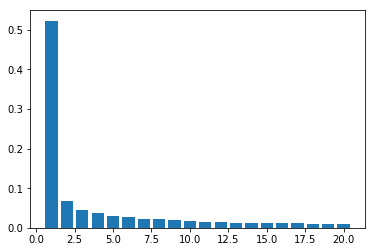

In [34]:
pca = PCA(n_components=20)

# Transform X_centered to X_pca via a fit_transform
products_cluster_counts_pca = pca.fit_transform(products_cluster_counts)
plt.bar(range(1, 21), pca.explained_variance_ratio_)

## Clustering Products

In [ ]:
# plot_kmeans_inertia(products_cluster_counts)

In [41]:
product_cluster_count = 5
km = KMeans(n_clusters=product_cluster_count)
product_clusters = km.fit_predict(products_cluster_counts)
product_ids = df_sentence_products_clusters.index

cluster_to_product_ids = {}
for product_cluster_index in range(0, product_cluster_count):
    df_product_indexes = product_ids[product_clusters == product_cluster_index]
    product_names = df_product.loc[df_product_indexes]['product_url']
    cluster_to_product_ids[product_cluster_index] = product_names
# P116609', 'P116610'    
cluster_to_product_ids

{0: product_id
 P102503    /wrinkle-revenge-rescue-protect-facial-cream-P...
 P122646                       /facial-soap-with-dish-P122646
 P140620                /hydra-pure-oil-free-moisture-P140620
 P148400    /galatee-confort-comforting-milky-creme-cleans...
 P173614    /benefiance-wrinkleresist24-day-emulsion-broad...
 P173617    /benefiance-wrinkleresist24-night-emulsion-P17...
 P173645             /pureness-moisturizing-gel-cream-P173645
 P173652    /bio-performance-advanced-super-revitalizing-c...
 P173667    /white-lucent-brightening-protective-cream-bro...
 P184113      /hydra-pure-vitamin-c-brightening-serum-P184113
 P184605                              /un-wrinkle-eye-P184605
 P196004                            /un-wrinkle-night-P196004
 P211326                          /citrus-facial-wash-P211326
 P214001                      /vita-mineral-day-cream-P214001
 P217909    /mousse-radiance-clarifying-self-foaming-clean...
 P217935    /eau-fraiche-douceur-micellar-cleansing-wat

## T-SNE

In [46]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=70).fit_transform(products_cluster_counts)


[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1264 samples in 0.002s...
[t-SNE] Computed neighbors for 1264 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1264
[t-SNE] Computed conditional probabilities for sample 1264 / 1264
[t-SNE] Mean sigma: 0.140728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.863258
[t-SNE] Error after 1000 iterations: 1.135204


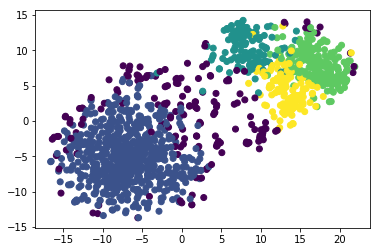

In [47]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=product_clusters)

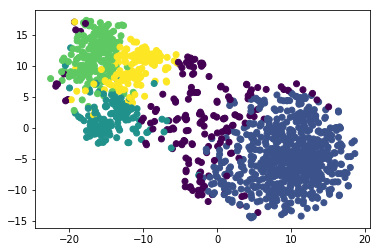

In [44]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=product_clusters)

In [58]:
# Top 5 sentences for 
# Write to CSV
df_product_filtered = df_product.loc[df_products_cluster_centered.index]
df_product_filtered['cluster'] = product_clusters
df_product_filtered['tsne_0'] = X_embedded[:, 0]
df_product_filtered['tsne_1'] = X_embedded[:, 1]
pd.to_csv(df_product_filtered)

,product_url,sku,category,brand,name,rating,detail_text,size_oz,price,cluster,tsne_0,tsne_1
product_id,,,,,,,,,,,,
P102503,/wrinkle-revenge-rescue-protect-facial-cream-P...,844480,moisturizers,DERMAdoctor,Wrinkle Revenge Rescue & Protect Facial Cream,4.2366,What it is:A lightweight concentrate that deli...,1.70,57,0,-11.478030,3.025054
P102504,/wrinkle-revenge-eye-balm-P102504,844472,eye creams & treatments,DERMAdoctor,Wrinkle Revenge Eye Balm,4.0591,What it is:A super-hydrating eye balm enriched...,0.50,50,2,7.188270,12.192310
P107306,/renewing-eye-cream-P107306,769836,eye creams & treatments,Murad,Renewing Eye Cream,4.0706,"What it is: A multiactive, antiaging treatment...",0.50,80,2,6.930768,11.728102
P112400,/oil-free-facial-lotion-P112400,1605526,moisturizer & treatments,Anthony,Oil Free Facial Lotion,4.3500,"What it is:A lightweight, smoothing moisturize...",2.50,30,1,-10.039310,-4.017670
P113608,/berry-nurturing-gel-mask-P113608,1910751,face masks,OLEHENRIKSEN,Berry Nurturing Gel Mask,4.4137,Which skin type is it good for? ✔ Dry ✔ Sensit...,3.20,36,3,15.419630,10.943239
P116609,/mega-rich-intensive-anti-aging-cellular-creme...,1699248,moisturizers,Peter Thomas Roth,Mega Rich Intensive Anti-Aging Cellular Creme,4.5526,What it is:An intensive moisturizing cream for...,1.70,85,1,-6.949644,3.201787
P116610,/mega-rich-intensive-anti-aging-cellular-eye-c...,876763,eye creams & treatments,Peter Thomas Roth,Mega Rich Intensive Anti-Aging Cellular Eye Creme,4.2227,What it is:An intensely hydrating eye cream cr...,0.76,65,2,9.387432,12.521203
P116805,/yogurt-cream-P116805,877225,moisturizers,KORRES,Greek Yoghurt Moisturizing Face Cream,4.3125,Which skin type is it good for?✔ Normal✔ Dry✔ ...,1.35,36,3,18.792240,6.994889
P12090,/hope-in-a-tube-eye-lip-cream-P12090,503102,eye creams & treatments,philosophy,Hope In A Tube Eye & Lip Cream,4.1873,"What it is:A versatile, high-density eye and l...",0.50,38,2,6.809595,11.053314


In [49]:
max(X_embedded[:, 1])

14.248423

In [39]:
x = np.array([[1, 2, 3], [4, 5, 6]], np.int32)
normalize(x)

array([[ 0.26726124,  0.53452248,  0.80178373],
       [ 0.45584231,  0.56980288,  0.68376346]])